## Step 1: Load data

In [1]:
import numpy as np
import jax
import jax.random as rd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from optical_flax.core import parameters
from optical_flax.generate_data import Rx_data, get_data
import pickle
from functools import partial


train_path = '/home/xiaoxinyu/data/0508'
test_path = '/home/xiaoxinyu/data/0517'
key = rd.PRNGKey(233)

def Rx(key, path, sps, FO, lw):
    with open(path+'/Tx_ch13', 'rb') as file:
        sigWDM_tx, symbWDM, param = pickle.load(file)

    with open(path+'/Channel_ch13', 'rb') as file:
        sigWDM, paramCh = pickle.load(file)

    data, paramRx, noise = Rx_data(key, sigWDM, symbWDM, sps, param, paramCh, FO, lw)
    return data, noise


def batch_data(data, Nlen=2000, Nstep=1000):
    from commplax.xop import frame
    sps = data.a['sps']
    y = jax.vmap(frame, in_axes=(0,None,None), out_axes=0)(data.y, Nlen*sps, Nstep*sps).reshape([-1,Nlen*sps,2])
    x = jax.vmap(frame, in_axes=(0,None,None), out_axes=0)(data.x, Nlen, Nstep).reshape([-1,Nlen,2])
    return y,x

data_train, n0 = Rx(rd.PRNGKey(123), train_path, sps=8, FO=0, lw=0)
data_test, n1 = Rx(rd.PRNGKey(234), test_path, sps=8, FO=0, lw=0)
y,x = batch_data(data_train)
y_test, x_test = batch_data(data_test)

 Rx_data complete, time cost(s):11.522738456726074
 Rx_data complete, time cost(s):3.910367488861084


## Load data

In [1]:
import numpy as np
import jax
import jax.random as rd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from optical_flax.core import parameters
from optical_flax.generate_data import Rx_data, get_data
import pickle
from functools import partial


train_path = '/home/xiaoxinyu/data/0508'
test_path = '/home/xiaoxinyu/data/0517'
key = rd.PRNGKey(233)

k=2
Nlen=2000
Nstep=1000
sps=2
steps=3
Nfft = Nlen*sps

def batch_data(data, Nlen=2000, Nstep=1000):
    from commplax.xop import frame
    sps = data.a['sps']
    y = jax.vmap(frame, in_axes=(0,None,None), out_axes=0)(data.y, Nlen*sps, Nstep*sps).reshape([-1,Nlen*sps,2])
    x = jax.vmap(frame, in_axes=(0,None,None), out_axes=0)(data.x, Nlen, Nstep).reshape([-1,Nlen,2])
    return y,x

## load data
with open('loading/data','rb') as file:
    data = pickle.load(file)
    data_train=data['data_train']
    data_test = data['data_test']
y,x = batch_data(data_train)
y_test, x_test = batch_data(data_test)

## MetaSSFM

Training: 100%|██████████| 60/60 [01:14<00:00,  1.25s/it]


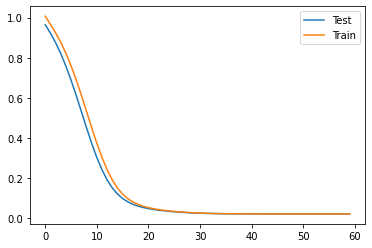

In [3]:
## Training Meta_DBP Model on a signal 
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from optical_flax.utils import show_tree
import optical_flax.base as base
from optical_flax.initializers import fdbp_init
from optical_flax.utils import realize
from commplax.module import core
import flax.linen as nn
import optax
from commplax import optim 
Signal = core.Signal

k = 2   # additional mimo symbols
steps = 3
Nlen= 2000
Nstep = 1000
sps=8
d_init, n_init = fdbp_init(data_train.a, xi=1.1, steps=steps, domain='frequency')
Net = partial(MetaSSFM,steps=steps, d_init=d_init, n_init=n_init, dtaps=Nlen*sps, ntaps=1, discard=sps*(500-k))
Net_vmap = nn.vmap(Net, variable_axes={'params':None}, split_rngs={'params':None})

class MyDBP(nn.Module):

    @nn.compact
    def __call__(self, signal):
        x, t = Net_vmap()(signal)
        # x [batch, N, 2]
        x = nn.Conv(features=2,kernel_size=((2*k+1)*sps,),strides=(sps,), param_dtype=jnp.complex64,dtype=jnp.complex64, padding='valid')(x)
        return Signal(x,t)
    
net = MyDBP()
LDBP = realize(net)
var0 = LDBP.init(rd.PRNGKey(2121), Signal(y[0:3,...]))
LDBP.apply(var0, Signal(y[0:3,...])).val.shape


tx = optax.adam(learning_rate=2e-3)

def loss(var, xi, yi): 
    x = LDBP.apply(var, Signal(yi))
    return jnp.mean(jnp.abs(x.val - xi[:,500:1500,:])**2)

@jax.jit
def update_param(var, opt_state, xi, yi):
    loss_val, grads = jax.value_and_grad(loss)(var, xi,yi)
    updates, opt_state = tx.update(grads, opt_state)
    var = optax.apply_updates(var, updates)
    return var, opt_state, loss_val

Loss = []
Loss_test = []
opt_state0 = tx.init(var0)


from tqdm import tqdm
for _ in tqdm(range(60), desc='Training'):
    for i in range(10):
        xi = x[99*i:99*(i+1), ...]
        yi = y[99*i:99*(i+1), ...]
        var0, opt_state0, l = update_param(var0, opt_state0, xi, yi)
        Loss.append(l)
    xi = x_test[99*2:99*3, ...]
    yi = y_test[99*2:99*3, ...]
    l = loss(var0, xi, yi)
    Loss_test.append(l)
    

plt.plot(Loss_test, label='Test')
plt.plot(Loss[::10], label='Train')
plt.legend()

In [4]:
print(Loss_test[-1])

0.020294042


## NNSSFM

In [5]:
fft = jnp.fft.fft
ifft = jnp.fft.ifft
from typing import Callable
from commplax.module.core import SigTime, Signal, zeros
from optical_flax.layers import NNSSFM


k = 0   # additional mimo symbols
steps = 3
d_init, n_init = fdbp_init(data_train.a, xi=1.1, steps=steps, domain='frequency')
Net0 = partial(NNSSFM,steps=steps, d_init=d_init, n_init=n_init, dtaps=Nlen*sps, ntaps=1, discard=sps*(500-k))
Net_vmap0 = nn.vmap(Net0, variable_axes={'params':None}, split_rngs={'params':None})

class NNDBP(nn.Module):

    @nn.compact
    def __call__(self, signal):
        x, t = signal
        x, t = Net_vmap0()(signal)
        # x [batch, N, 2]
        x = nn.Conv(features=2,kernel_size=((2*k+1)*sps,),strides=(sps,), param_dtype=jnp.complex64,dtype=jnp.complex64, padding='valid')(x)
        return Signal(x,t)
    
nn_net = NNDBP()
nn_LDBP = realize(nn_net)
var1 = nn_LDBP.init(rd.PRNGKey(2121), Signal(y[0:3,...]))
# nn_LDBP.apply(var1, Signal(y[0:3,...])).val.shape


tx = optax.adam(learning_rate=1e-2)
def nn_loss(var, xi, yi): 
    x = nn_LDBP.apply(var, Signal(yi))
    return jnp.mean(jnp.abs(x.val - xi[:,500:1500,:])**2)

@jax.jit
def nn_update_param(var, opt_state, xi, yi):
    loss_val, grads = jax.value_and_grad(nn_loss)(var, xi,yi)
    updates, opt_state = tx.update(grads, opt_state)
    var = optax.apply_updates(var, updates)
    return var, opt_state, loss_val

nn_Loss = []
nn_Loss_test = []
opt_state1 = tx.init(var1) 

In [6]:
from tqdm import tqdm
for _ in tqdm(range(60), desc='Training'):
    for i in range(10):
        xi = x[99*i:99*(i+1), ...]
        yi = y[99*i:99*(i+1), ...]
        var1, opt_state1, l = nn_update_param(var1, opt_state1, xi, yi)
        nn_Loss.append(l)
    xi = x_test[99*1:99*3, ...]
    yi = y_test[99*1:99*3, ...]
    l = nn_loss(var1, xi, yi)
    nn_Loss_test.append(l)

Training: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]


0.01963446


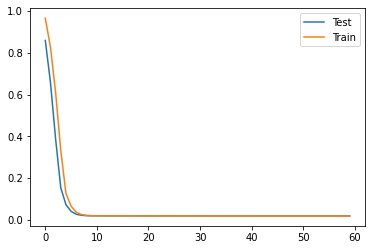

In [7]:
plt.plot(nn_Loss_test, label='Test')
plt.plot(nn_Loss[2::10], label='Train')
plt.legend()
print(nn_Loss_test[-1])

## attention

In [8]:
import jax.numpy as jnp
import jax
import jax.random as rd 
import numpy as np
import flax.linen as nn 
from optical_flax.utils import show_tree
net = nn.SelfAttention(num_heads=5, dtype=jnp.complex64, param_dtype=jnp.complex64)

In [9]:
var = net.init(rd.PRNGKey(0), jnp.ones([3, 100, 20]))
net.apply(var, jnp.ones([3,100,20])).shape

(3, 100, 20)

In [10]:
show_tree(var)

FrozenDict({
    params: {
        key: {
            bias: (5, 4),
            kernel: (20, 5, 4),
        },
        out: {
            bias: (20,),
            kernel: (5, 4, 20),
        },
        query: {
            bias: (5, 4),
            kernel: (20, 5, 4),
        },
        value: {
            bias: (5, 4),
            kernel: (20, 5, 4),
        },
    },
})

: 